<a href="https://colab.research.google.com/github/sayan0506/Facial-Key-Points-Detection-using-Neural-Network-/blob/master/Facial_landmark_detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
import numpy as np
from keras import layers
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
print(tf.version.VERSION)

2.3.0


**Drive mount**

The dataset is in Emotion AI folder in drive.

In [2]:
# Dataframe creation for the facial keypoints
facial_keypoints = pd.read_csv('/content/drive/My Drive/Emotional AI/KeyFacialPoints.csv')

In [3]:
print('Dataframe info:')
facial_keypoints.info()

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 

In [4]:
print('Facial keypoints dataframe visualization: \n')
facial_keypoints.head(3)

Facial keypoints dataframe visualization: 



,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


* The dataframe consists of 2140 samples of images, where each row of the dataframe consists of 30 different facial keypoints along with the image at the 31st column.
* All the pixel values of image are stored together as a string in the **'Image'** column corresponding to each of the datapoint.
* Each of the image is corresponding to 96*96 pixels, stored in 'str' format under the'Image' column in the dataframe.
* The user-defined function is used to extract the image info from strings and convert each string to (96,96) numpy array. 
* Each of the images stored are single channels of size (96,96).

In [5]:
# String to np.ndarray conversion
facial_keypoints['Image'] = facial_keypoints['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96,96))

In [6]:
print('Individual reshaped image shape: ',facial_keypoints['Image'][0].shape)

Individual reshaped image shape:  (96, 96)


# Missing Value Check

Checking whether any missing data is there in the dataframe corresonding to any datapoint.

In [7]:
if sum(facial_keypoints.isnull().sum()) == 0:
  print('No missing data is there.')
else:
  print('Missing values are there!')

No missing data is there.


In [8]:
print('Attribute-wise summary of all the datapoints:')
facial_keypoints.describe()

Attribute-wise summary of all the datapoints:


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,22.361617,38.034571,56.147991,29.222304,79.617523,29.656570,39.272084,29.413747,15.761707,30.452947,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,2.768804,2.654903,2.819914,2.867131,3.312647,3.627187,2.609648,2.842219,3.337901,3.644342,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,11.054589,26.521633,35.581733,15.859361,55.549929,10.522325,25.060327,16.476000,3.826243,13.224453,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,20.631964,36.569765,54.562757,27.590944,77.732395,27.658656,37.555192,27.798773,13.540535,28.268263,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,22.529600,37.876900,56.239984,29.468466,79.797607,29.753523,39.247681,29.528098,15.760876,30.333323,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,24.202338,39.401034,57.926361,31.079433,81.559651,31.763791,40.824154,31.134740,17.871569,32.661300,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,40.050971,50.002113,67.752000,40.293408,94.269957,48.823425,51.300571,39.445859,39.676082,44.857962,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


# Images Visualization

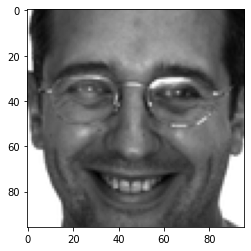

In [9]:
# Let's plot a random image from the dataset.
i = np.random.randint(1, len(facial_keypoints))
plt.imshow(facial_keypoints['Image'][i], cmap = 'gray')

* Facial keypoints are plotted on the dynamic number(Here 16) of random images using ***plot_random_images()*** function.
* Gray scale images are plotted first.
* Facial keypoints are then plotted on it, thus 30 keypoints corresponding to 15 features are plotted here.
* Each keypoint has coordinate (x,y), represented by consecuetive two attributes in the dataframe.


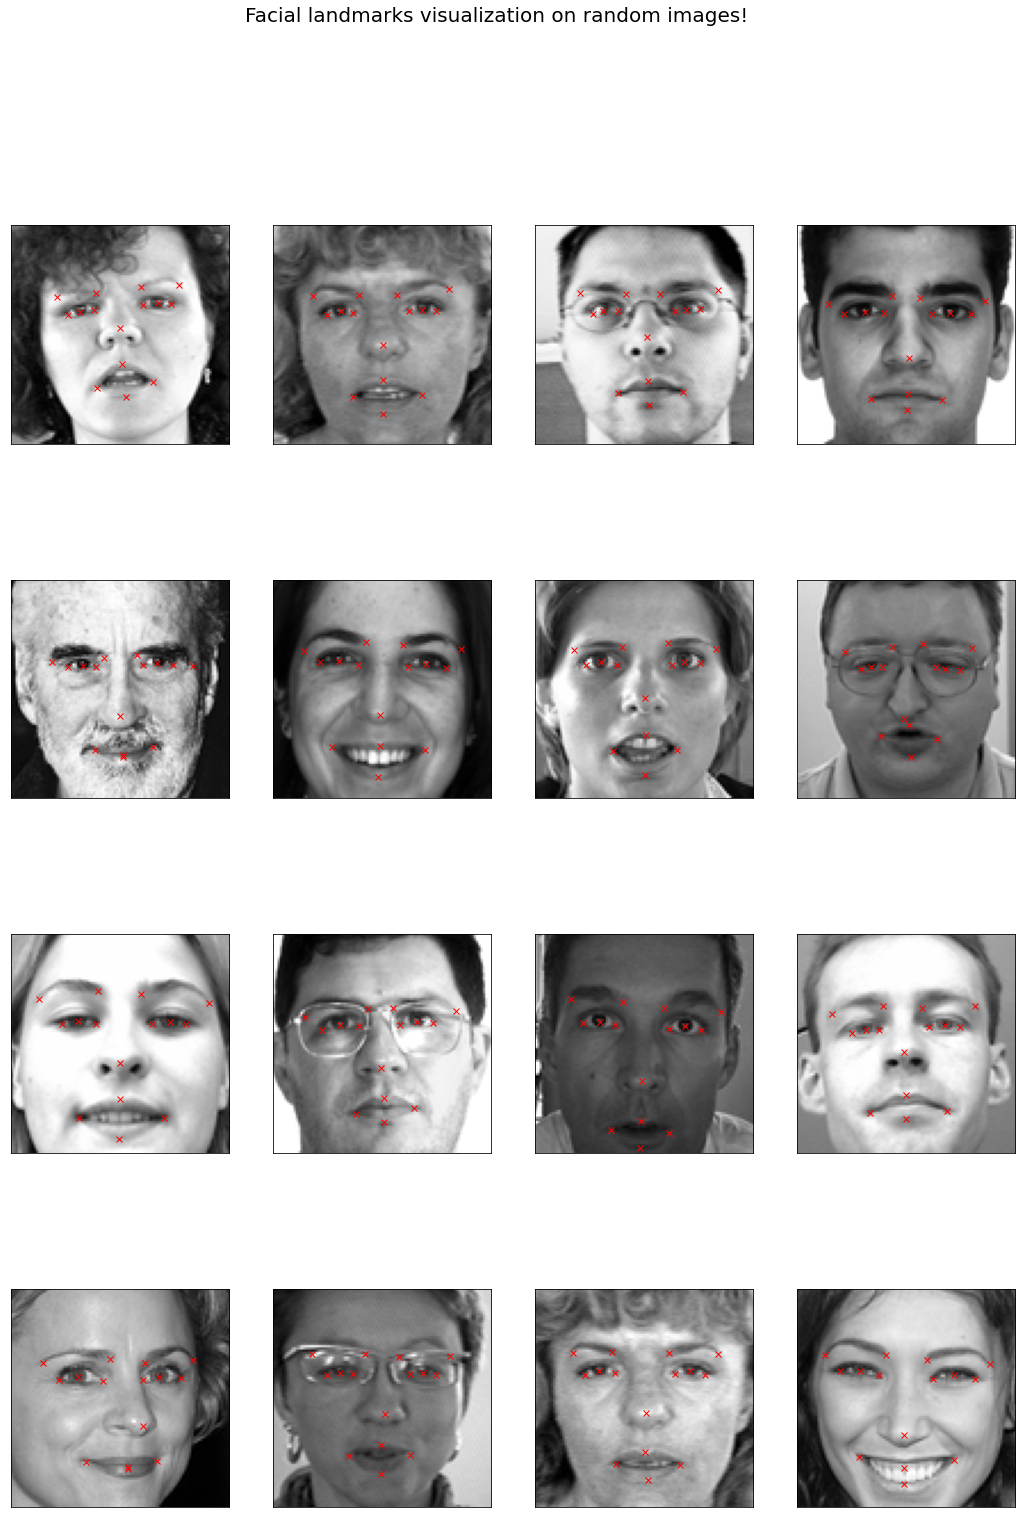

In [10]:
# Visualizing the random image with facialkeypoints on it

# Pyplot figure is created

def plot_random_images(img_count):
  fig = plt.figure(figsize = (18,25))
  fig.suptitle('Facial landmarks visualization on random images!',fontsize = 20)
  for c in range(img_count):
    i = np.random.randint(1, len(facial_keypoints))
    fig.add_subplot(int(np.sqrt(img_count)),int(np.sqrt(img_count)),c+1)
    # gray scale images are plotted first
    plt.imshow(facial_keypoints['Image'][i],cmap='gray')
    # facial keypoints are then plotted on it, thus 30 keypoints corresponding to 15 features are plotted here
    # Each keypoint has coordinate (x,y), represented by consecuetive two attributes in the dataframe 
    for j in range(1,len(facial_keypoints.columns),2):
      plt.plot(facial_keypoints.loc[i][j-1],facial_keypoints.loc[i][j],'rx')
      plt.xticks([])
      plt.yticks([])
  plt.show()

# Plot 16 random images, whatever the count of images we want to visualize, that can be passed to that function.
plot_random_images(16)

# Data Augmentation

In [11]:
facial_keypoints_copy = facial_keypoints.copy()

In [12]:
# Extracting features of the keypoints

columns = facial_keypoints_copy.columns[:-1]
print('Features of keypoints:\n',columns)

Features of keypoints:
 Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


Now, Image Augmentation techniques will be implmented, two following techniques are used:
* **Horizontal flip of images.**

* **Brightness enhancement of the images.**

**Note:** After implementing the image augmentation, like the **Horizontal Flip**, the facial keypoints are needed to be adjusted or flipped accordingly. 

Horizontal Fliiping is implemented here.

In [13]:
# Horizontal Fliiping is implemented here.
facial_keypoints_copy['Image'] = facial_keypoints_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

Effect of Image Augmentaion Augmentation:


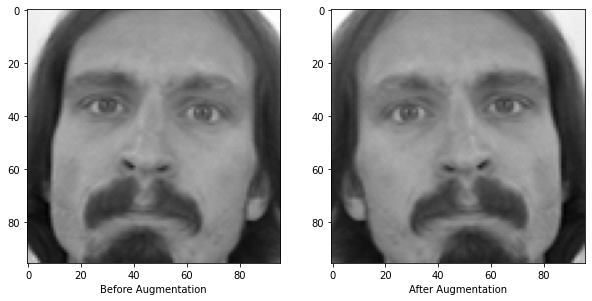

In [14]:
print('Effect of Image Augmentaion Augmentation:')
fig_aug = plt.figure(figsize=(10,10))
fig_aug.add_subplot(1,2,1)
plt.imshow(facial_keypoints['Image'][0],cmap='gray')
plt.xlabel('Before Augmentation')
fig_aug.add_subplot(1,2,2)
plt.imshow(facial_keypoints_copy['Image'][0],cmap='gray')
plt.xlabel('After Augmentation')
plt.show()

* Here, the facial keypoints are adjusted to fit the augmented image.
* As the images are flipped horizontally, so we need to adust the landmarks corresponding to X-axis only.

***Adjustment=>   adjusted_value = (96 - initial_value)*** 

Here, 96 is the image resolution along the x-axis.

In [15]:
# keypoints adjustment

for col,atr in enumerate(columns):
  if(col % 2 == 0):
    facial_keypoints_copy[atr] = facial_keypoints_copy[atr].apply(lambda x: 96. - float(x))


Effect of Image Augmentaion after keypoint adjustment:



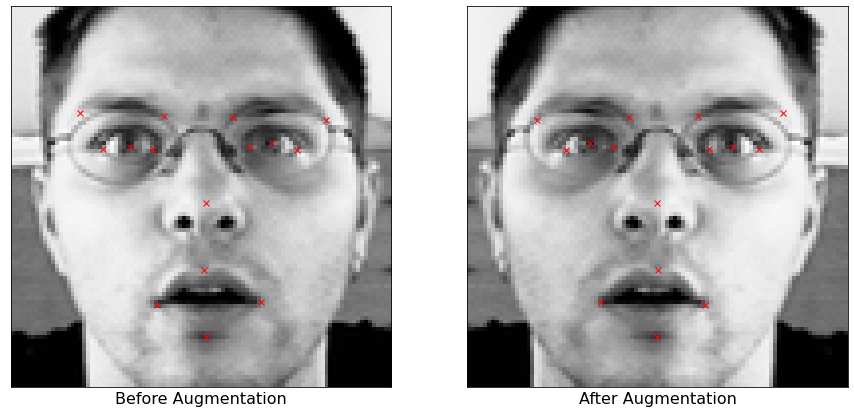

In [16]:
print('Effect of Image Augmentaion after keypoint adjustment:\n')
image_no  = np.random.randint(1, len(facial_keypoints))
aug_comp = plt.figure(figsize = (15,15))
for i_c, df in enumerate([facial_keypoints, facial_keypoints_copy]):
  aug_comp.add_subplot(1,2,i_c + 1)
  plt.imshow(df['Image'][image_no], cmap = 'gray')
  for j in range(1,len(df.columns),2):
      plt.plot(df.loc[image_no][j-1],df.loc[image_no][j],'rx')
      plt.xticks([])
      plt.yticks([])
      plt.xlabel('{0}'.format(['Before Augmentation', 'After Augmentation'][i_c]), fontsize = 16)
  
plt.show()


Brightness enhancement augmentation technique is implemented by multiplying each pixel of the image with a uniform random number betweeen 1 and 2, but restricting the enhanced pixel value within a range between 0 and 255

Effect of Image Augmentaion after brightness adjustment:



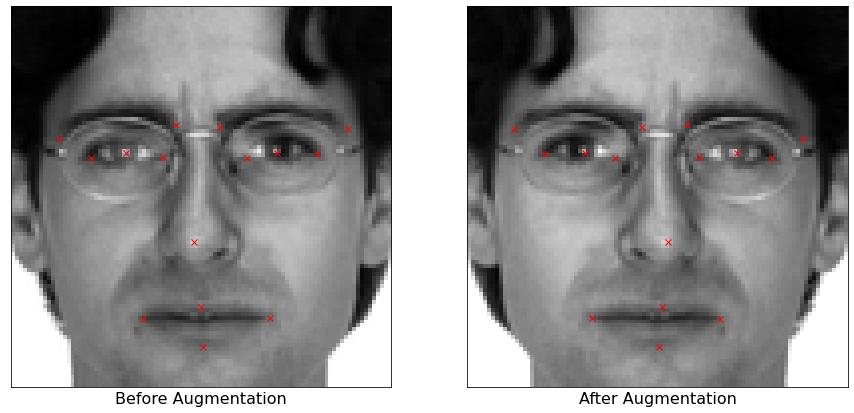

In [17]:
# random.uniform(1,2) returns uniform random number between 1 and 2, if uniform is not used, it would have returned biased value.
# np.clip() helps to restrict the multiplied value within the range between 0 and 255. 
facial_keypoints_copy['Image'] = facial_keypoints_copy['Image'].apply(lambda x: np.clip(x * random.uniform(1,2), 0, 255)) 

print('Effect of Image Augmentaion after brightness adjustment:\n')
image_no  = np.random.randint(1, len(facial_keypoints))
aug_comp = plt.figure(figsize = (15,15))
for i_c, df in enumerate([facial_keypoints, facial_keypoints_copy]):
  aug_comp.add_subplot(1,2,i_c + 1)
  plt.imshow(df['Image'][image_no], cmap = 'gray')
  for j in range(1,len(df.columns),2):
      plt.plot(df.loc[image_no][j-1],df.loc[image_no][j],'rx')
      plt.xticks([])
      plt.yticks([])
      plt.xlabel('{0}'.format(['Before Augmentation', 'After Augmentation'][i_c]), fontsize = 16)
  
plt.show()


After implementing image Augmentations, both the dataframes are concatenated to make a larger dataframe of many samples.

In [18]:
# Both the dataframes are passed as a tuple (df1, df2) to the np.concatenate() function

facial_keypoints_augmentation = np.concatenate((facial_keypoints, facial_keypoints_copy))
print('Shape of concatenated dataframe: ',facial_keypoints_augmentation.shape)

Shape of concatenated dataframe:  (4280, 31)


# Images normalization, data preperation for training

Images are normalized, and x_train, y_train, x_test, y_test are preperated from the concatenated dataframe for training using train_test_split.

Images are only stored as numpy array after normalization.

In [19]:
# The images are first stored in a list using list comprehension
# The list is then converted into a numpy array with a data-type of float32 
# Then the new axis is added to images array which correspond to the number of channel of image(axis = 3)
# Then the images are normalized(1./255.)
images = np.expand_dims(np.array([facial_keypoints_augmentation[i][30] for i in range(facial_keypoints_augmentation.shape[0])], dtype = np.float32), axis = 3)/255.
print('Image array shape: ', images.shape)

Image array shape:  (4280, 96, 96, 1)


The facial keypoints corresponds to the final dataframe are stored in different numpy array named keypoints, which corresponds to 30 attributes for 15 different types of facial landmarks.   

In [20]:
# facial keypoints attributes are stored as a numpy array, where each elemnt is stored as float32 datatype.

keypoints = np.array([facial_keypoints_augmentation[i][:30] for i in range(facial_keypoints_augmentation.shape[0])], dtype = np.float32)
print('Shape of the keypoints array: ', keypoints.shape) 

Shape of the keypoints array:  (4280, 30)


Train test split => the dataset is split into 80 percent train data, 20 percent validation data(test).

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(images, keypoints, test_size = 0.2)

In [22]:
print('Training images shape: {0}\nTraining labels shape: {1}\nValidation images shape: {2}\nValidation labels shape: {3}\n'.format(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape))

Training images shape: (3424, 96, 96, 1)
Training labels shape: (3424, 30)
Validation images shape: (856, 96, 96, 1)
Validation labels shape: (856, 30)



# Building the Convolution Neural Network(CNN)

In this project **RESNET(Residual Network)** is used which incorporates the concept of **'Skip Connection'**, which helps in training 152 layers without *'Vanishing gradient'* error, which occurs while implementing a Deep CNN. 

In this project **ResNet50** architecture is used, as shown below:

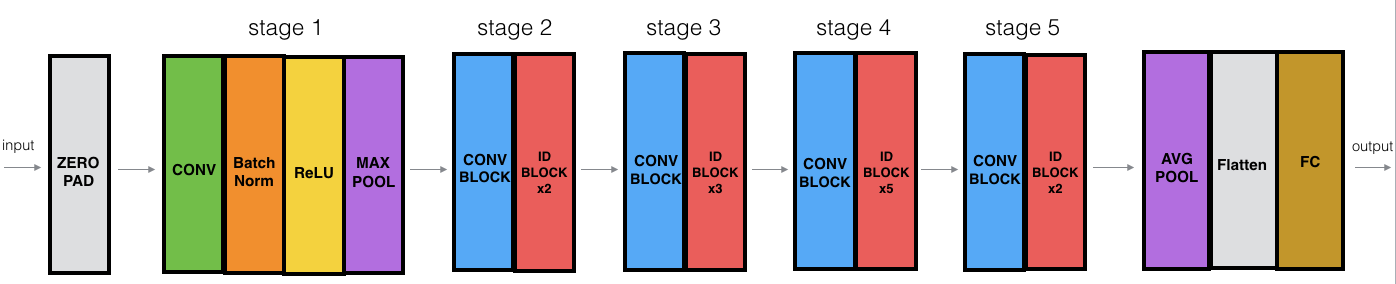

[image link](https://www.deeplearning.ai/)

In [23]:
# defining the residual block

def residual_block(x, filters, stage):
  ## defining the convolution block

  # for the shortcut path
  x_copy = x

  f1, f2, f3 = filters

  # Main path
  x = Conv2D(f1, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(x)
  #x = MaxPooling2D((2,2))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_a')(x)
  x = Activation('relu')(x)
  
  x = Conv2D(f2, (3,3), strides = (1,1), padding = 'same', name = 'res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(x)
  # x = MaxPooling2D((2,2))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_b')(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_c')(x)
  
  # shortcut path
  x_copy = Conv2D(f3, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(x_copy)
  #x_copy = MaxPooling2D((2,2))(x_copy)
  x_copy = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_copy')(x_copy)

  # summing data from main path and shortcut path
  x = Add()([x, x_copy])
  x = Activation('relu')(x)


  ## defining the identity block 1

  # shortcut path
  x_copy = x

  # Main path
  x = Conv2D(f1, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_identity1_a', kernel_initializer = glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity1_a')(x)
  x = Activation('relu')(x)
  
  x = Conv2D(f2, (3,3), strides = (1,1), padding = 'same', name = 'res_'+str(stage)+'_identity1_b', kernel_initializer= glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity1_b')(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_identity1_c', kernel_initializer= glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity1_c')(x)

  # summing data from main path and shortcut path
  x = Add()([x, x_copy])
  x = Activation('relu')(x)

  ## defining the identity block 2

  # shortcut path
  x_copy = x

  # Main path
  x = Conv2D(f1, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_identity2_a', kernel_initializer= glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity2_a')(x)
  x = Activation('relu')(x)
  
  x = Conv2D(f2, (3,3), strides = (1,1), padding = 'same', name = 'res_'+str(stage)+'_identity2_b', kernel_initializer= glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity2_b')(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1), strides = (1,1), name = 'res_'+str(stage)+'_identity2_c', kernel_initializer= glorot_uniform(seed = 0))(x)
  x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity2_c')(x)

  # summing data from main path and shortcut path
  x = Add()([x, x_copy])
  x = Activation('relu')(x)

  return x

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

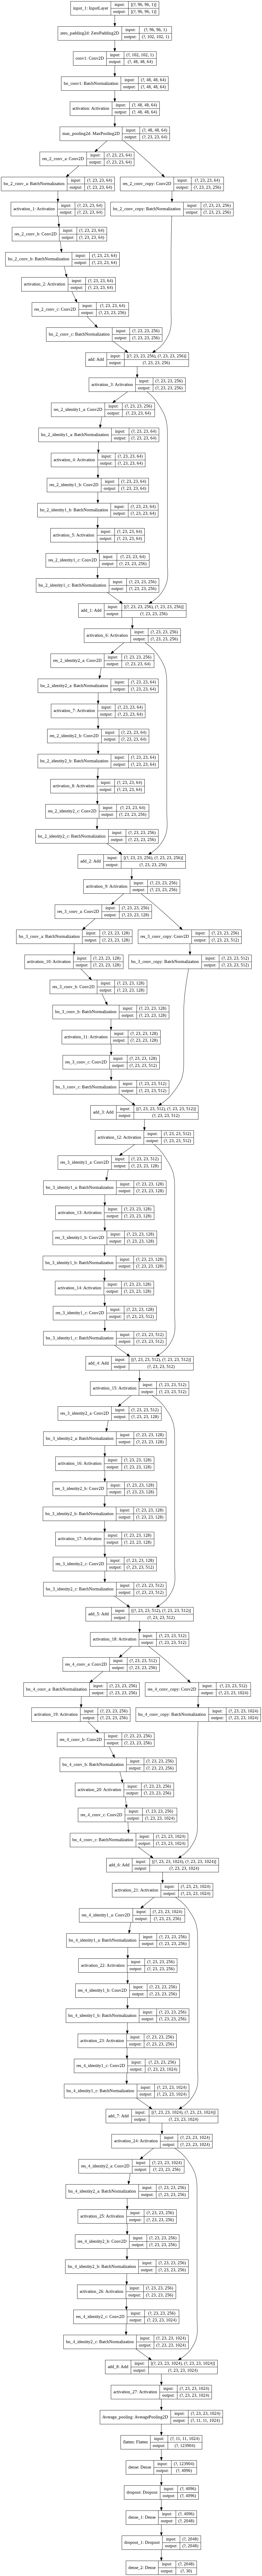

In [24]:
# Implementation of the Residual Network

input_shape = (96,96,1)

x_input = Input(input_shape)

#  Zero-padding
x = ZeroPadding2D(padding=(3,3))(x_input)

# Stage 1
x = Conv2D(64, (7,7), strides = (2,2), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(x)
x = BatchNormalization(axis = 3, name = 'bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides = (2,2))(x)

# Stage 2
x = residual_block(x, filters = [64,64,256], stage = 2)

# Stage 3
x = residual_block(x, filters = [128,128,512], stage = 3)

# Stage 4
x = residual_block(x, filters = [256,256,1024], stage = 4)

# Averagepooling 
x = AveragePooling2D(pool_size=(2,2), name = 'Average_pooling')(x)

# FInal
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.1)(x)

# Output classes are categorical 
x = Dense(30, activation='relu')(x)

model = Model(inputs = x_input, outputs = x)
model.summary()
print('Model architecture\n')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Compile And Training Deep Learning Model

In [25]:
# here we are using Adam optimizer
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# model compilation
model.compile(optimizer=adam, loss = 'mse', metrics = ['accuracy'])

In [26]:
# model checkpoints
checkpoint = ModelCheckpoint('best_model.h5',monitor = 'val_loss', verbose = 1, mode = 'min')

In [27]:
history = model.fit(x=x_train, y=y_train, batch_size=16, epochs = 20, verbose = 1, validation_data= (x_valid, y_valid))

Epoch 1/20
214/214 [==============================] - 42s 197ms/step - loss: 8680.8613 - accuracy: 0.0207 - val_loss: 746.8534 - val_accuracy: 0.0187
Epoch 2/20
214/214 [==============================] - 42s 197ms/step - loss: 665.2108 - accuracy: 0.0391 - val_loss: 708.2232 - val_accuracy: 0.0187
Epoch 3/20
214/214 [==============================] - 43s 200ms/step - loss: 390.0650 - accuracy: 0.5117 - val_loss: 352.2593 - val_accuracy: 0.6682
Epoch 4/20
214/214 [==============================] - 43s 202ms/step - loss: 321.2548 - accuracy: 0.5987 - val_loss: 295.7080 - val_accuracy: 0.6145
Epoch 5/20
214/214 [==============================] - 43s 203ms/step - loss: 308.0951 - accuracy: 0.6043 - val_loss: 304.3565 - val_accuracy: 0.5748
Epoch 6/20
214/214 [==============================] - 44s 203ms/step - loss: 304.3845 - accuracy: 0.6072 - val_loss: 281.4327 - val_accuracy: 0.5584
Epoch 7/20
214/214 [==============================] - 44s 205ms/step - loss: 291.6412 - accuracy: 0.6119 

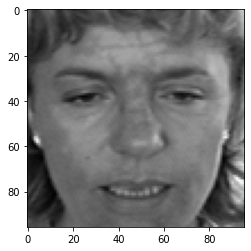

In [28]:
plt.imshow(np.squeeze(x_train[0]), cmap = 'gray')


In [29]:
y_train[0]

array([67.51064 , 38.390038, 26.226112, 39.1997  , 61.034264, 39.1997  ,
       76.01026 , 39.1997  , 31.89283 , 39.1997  , 19.749737, 40.41419 ,
       58.20136 , 31.104906, 81.27125 , 30.295246, 35.535397, 32.319397,
       12.464603, 29.485584, 49.701736, 59.43668 , 64.67683 , 78.86491 ,
       31.488   , 79.67457 , 48.892075, 74.81751 , 48.487244, 90.19743 ],
      dtype=float32)